In [1]:
import tarfile
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from cmapPy.pandasGEXpress.parse import parse
from functools import reduce
import json

In [41]:
cancer_celllines = {"brca" : "MCF7", "luad": "A549", "lusc" : "A549", "lihc" : "HEPG2", "prad" : "PC3", "coad" : "HT29"}
cancer_names = ["lusc"]#, "brca","luad", "prad", "coad"]
methods = ["mds"] #, "hub", "mds", "vertex", "bfs"]
gene_sets = ["equal_set"]

In [22]:
def read_gctx_file(file, cancer_name):
    cmp_data = parse(file)
    metadata = cmp_data.row_metadata_df
    cmap_scores = cmp_data.data_df
    # cmapdrugs_scores
    cell_line = cancer_celllines[cancer_name]
    metadata.reset_index(drop = True, inplace = True)
    mcf7_brd_df = metadata[metadata['pert_id'].str.contains('BRD') & metadata['cell_id'].str.contains(cell_line) & metadata['pert_type'].str.contains('trt_cp')]
    
    cmap_scores.reset_index(inplace=True)
    cmap_scores.columns = ["cid", "TAG"]

    mcf7_scores = cmap_scores[cmap_scores['cid'].str.contains('BRD') & cmap_scores['cid'].str.contains(cell_line)]
    # mcf7_scores['pert_id'] = mcf7_scores['cid'].str.split(':', expand=True)[0]
    mcf7_scores.loc[:, 'pert_id'] = mcf7_scores['cid'].str.split(':', expand=True)[0]

    merged_df = pd.merge(mcf7_scores, mcf7_brd_df[['pert_id', 'pert_iname', 'pert_type']], on='pert_id')
    final_df = merged_df[['pert_id', 'pert_iname', 'TAG']]
    cmap_name_cids = pd.read_csv(f"C:/Users/areeba khan/Documents/UdS/Master Thesis/CMAP_Output/{cancer_name}/{cancer_name}_cmap_cmps_cid.txt", header=None, sep="\t")

    cmap_name_cids.columns = ['pert_iname', 'cid']

    cmap_name_cids['pert_iname'] = cmap_name_cids['pert_iname'].str.lower()

    cmap_name_cids.drop_duplicates(inplace=True)

    cmap_name_cids = cmap_name_cids.dropna(subset=['cid'])

    cmap_name_cids = cmap_name_cids.groupby('pert_iname')['cid'].agg(lambda x: ','.join(x.astype(str).unique())).reset_index()
    cmap_name_cids['pert_iname'] = cmap_name_cids['pert_iname'].str.lower()

    final_df['pert_iname'] = final_df['pert_iname'].str.lower()
    cmap = pd.merge(cmap_name_cids, final_df[['pert_id', 'pert_iname', 'TAG']], on='pert_iname')

    cmap['pert_iname'] = cmap['pert_iname'].str.lower()

    cmap_grouped = cmap.groupby(['pert_iname', 'TAG', 'pert_id'], as_index=False).agg({
        'cid': lambda x: ','.join(x)
    })

    cmap = cmap_grouped.drop_duplicates()

    def unique_join(val):
        cids = val.split(',')
        cids = [str(int(float(cid))) for cid in cids]
        return ','.join(sorted(set(cids)))

    cmap['cid'] = cmap['cid'].apply(unique_join)

    cmap.reset_index(drop=True, inplace=True)

    return cmap

In [23]:
def drug_filter(cid_file, ref_drug):
    with open(cid_file, "r") as file:
        lines = file.readlines()

    drugs = []
    ids = []

    for line in lines:
        parts = line.strip().split("\t")
        if len(parts) == 2:
            drugs.append(parts[0].lower())
            ids.append(parts[1])

    df = pd.DataFrame({"Drug": drugs, "Cid": ids})

    # df.dropna(inplace=True)
    # df.reset_index(drop=True, inplace=True)
    df = df.groupby('Drug')['Cid'].agg(lambda x: ','.join(x.astype(str).unique())).reset_index()
    df['Drug'] = df['Drug'].str.lower()
    df_merge = pd.merge(df, ref_drug["Drug"], on = "Drug")
    return df_merge

In [24]:
def remove_drug(drug_df, cmap):
    keep = []
    for i in range(len(drug_df)):
        cids = drug_df.iloc[i, 1].split(",") 
        for k in range(len(cmap)):
            cids_cmap = str(cmap.iloc[k, 3])
            # print(cids_cmap)
            if isinstance(cids_cmap, str):
                cids_cmap = cids_cmap.split(",")
                if any(cid in cids_cmap for cid in cids):
                    keep.append(i)
                    break

    filtered_drug = drug_df.iloc[keep]
    return filtered_drug

In [25]:
def function_call(file, cancer_name):    
    cmap = read_gctx_file(file, cancer_name)
    # print(cmap)
    ttd_drug = pd.read_csv(f"C:/Users/areeba khan/Documents/UdS/Master Thesis/Drugs/{cancer_name}/ttd_drugs.txt", sep="\t", header=None, names = ["Drug", "ID"])
    ttd_drug.iloc[:, 0] = ttd_drug.iloc[:, 0].str.lower()
    ttd_drug.drop_duplicates(inplace=True)

    nci_ref_drugs = pd.read_csv(f"C:/Users/areeba khan/Documents/UdS/Master Thesis/Drugs/{cancer_name}/nci_drugs.txt", sep="\t", header=None, names = ["Drug"])
    nci_ref_drugs.iloc[:, 0] = nci_ref_drugs.iloc[:, 0].str.lower()
    nci_ref_drugs.drop_duplicates(inplace=True)

    # print("TTD Drugs:")
    # print(ttd_drug)
    # print("NCI Drugs:")
    # print(nci_ref_drugs)

    ttd_drug_cids = drug_filter(f"C:/Users/areeba khan/Documents/UdS/Master Thesis/Drugs/{cancer_name}/ttd_cid.txt", ttd_drug)
    nci_drug_cids = drug_filter(f"C:/Users/areeba khan/Documents/UdS/Master Thesis/Drugs/{cancer_name}/nci_cid.txt", nci_ref_drugs)

    # if len(ttd_drug_cids) < 20 and len(nci_drug_cids) < 20:
    #     ttd = ttd_drug_cids
    #     nci = nci_drug_cids
    # else:
    nci = remove_drug(nci_drug_cids, cmap)
    ttd = remove_drug(ttd_drug_cids, cmap)

    approved_drugs = pd.concat([ttd, nci], ignore_index=True)
    approved_drugs['Drug'] = approved_drugs['Drug'].str.lower()
    approved_drugs = approved_drugs.groupby('Drug')['Cid'].apply(lambda x: ','.join(x)).reset_index()

    approved_drugs.drop_duplicates(inplace=True)

    approved_drugs['Cid'] = approved_drugs['Cid'].apply(lambda x: ','.join(set(x.split(','))))

    keep = []
    for i in range(len(approved_drugs)):
        cids = set(approved_drugs.iloc[i, 1].split(','))
        for k in range(len(approved_drugs)):
            cids_cmap = set(approved_drugs.iloc[k, 1].split(','))
            cut = cids.intersection(cids_cmap)
            if cut and len(cids) < len(cids_cmap):
                keep.append(i)
                break

    if keep:
        approved_drugs = approved_drugs.drop(keep).reset_index(drop=True)
    
    cmap_grouped_sorted = cmap.sort_values(by='TAG', ascending=True).reset_index(drop=True)
    #print(approved_drugs)
    
    return cmap_grouped_sorted, approved_drugs

In [26]:
def overlap_coefficient(compound_df, approved_drugs_df, n):
    count = 0
    first_n_items = compound_df.head(n)
    # print(first_n_items)
    # print(approved_drugs_df)
    overlapping_compounds = []    
    for i, row in first_n_items.iterrows():
        cids = str(row['cid']).split(",")
        cmp_name = row["pert_iname"]
        pert_id = row["pert_id"]
        # print(cids)
        for j, approved_row in approved_drugs_df.iterrows():
            cids_cmap = str(approved_row['Cid']).split(",")
            drug_name = approved_row["Drug"]
            # if any(cid in cids_cmap for cid in cids):
            #     count += 1
            #     break
            overlap = [cid for cid in cids if cid in cids_cmap]
            if overlap:
                count += 1
                overlapping_compounds.append({
                    "cmap_compunds": cmp_name,
                    "drug" : drug_name,
                    "overlap_cid" : overlap,
                    "pert_id" : pert_id
                })
    
    min_size = min(len(first_n_items), len(approved_drugs_df))
    # print(count)
    coeff = count / min_size
    return round(coeff * 100), overlapping_compounds

In [27]:
def overlap_coefficient_relevant(compound_df, approved_drugs_df):
    # Filter compounds with TAG value <= -95
    filtered_compound_df = compound_df[compound_df['TAG'] <= -95]
    
    count = 0
    
    for i, row in filtered_compound_df.iterrows():
        cids = str(row['cid']).split(",")
        for j, approved_row in approved_drugs_df.iterrows():
            cids_cmap = str(approved_row['Cid']).split(",")
            if any(cid in cids_cmap for cid in cids):
                count += 1
                break
    
    min_size = min(len(filtered_compound_df), len(approved_drugs_df))
    if min_size > 0:
        coeff = count / min_size
    else:
        coeff = 0
    return round(coeff * 100)


c:\Users\areeba khan\AppData\Local\Programs\Python\Python310\lib\site-packages\cmapPy\pandasGEXpress\parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
c:\Users\areeba khan\AppData\Local\Programs\Python\Python310\lib\site-packages\cmapPy\pandasGEXpress\parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
C:\Users\areeba khan\AppData\Local\Temp\ipykernel_14204\1570581819.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

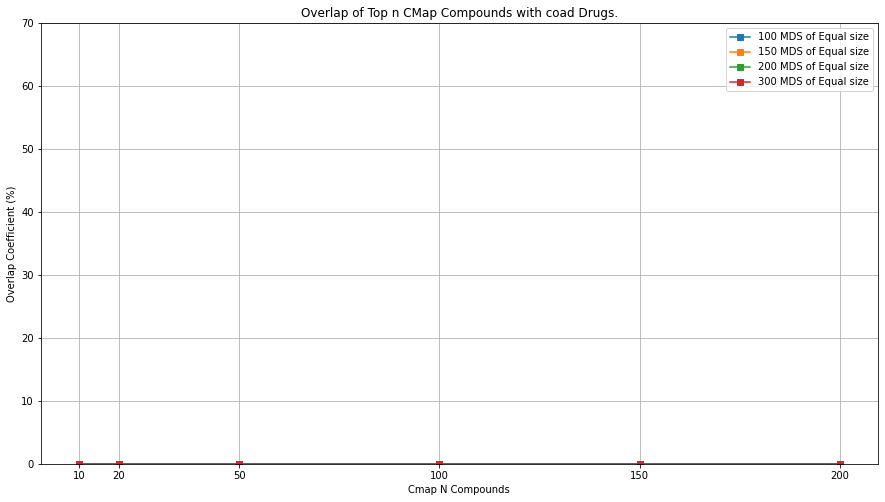

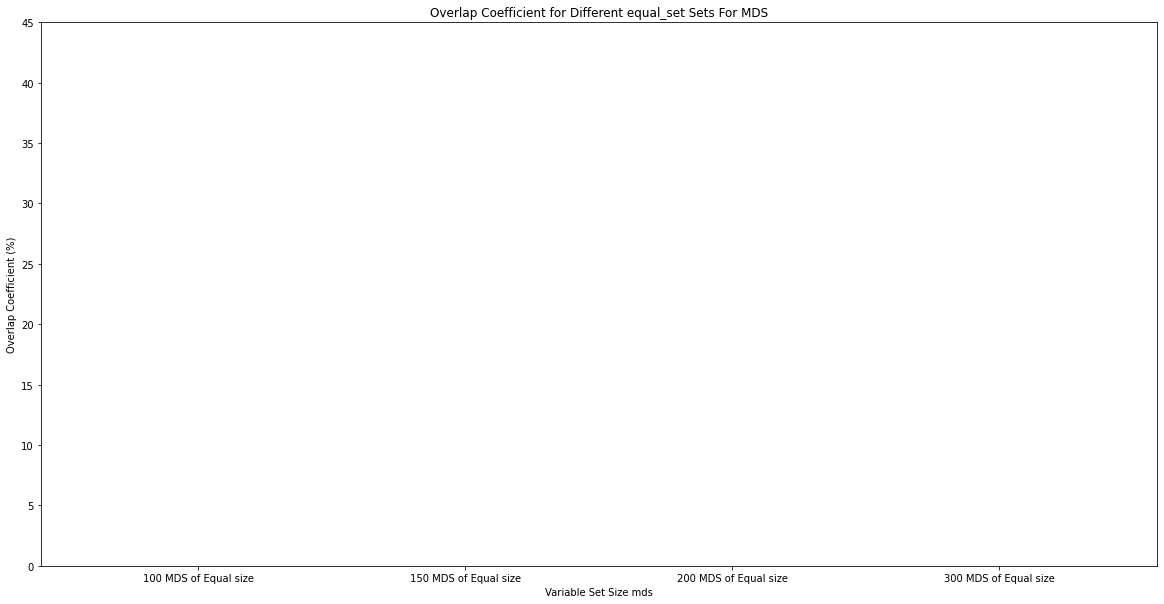

In [47]:
# Function for plotting overlap for n Compounds
def overlap_plot(dicts, labels, save_path, cancer):
    x_values = [10, 20, 50, 100, 150, 200]

    fig, ax = plt.subplots(figsize=(15, 9))
    plt.subplots_adjust(bottom=0.2)
    
    for i, data_dict in enumerate(dicts, start=1):
        label = labels[i-1] if i <= len(labels) else f'Dataset {i}'
        y_values = []
        for x in x_values:
            key = f'Top {x} Compounds Overlap'
            if key in data_dict:
                y_values.append(data_dict[key])
            else:
                y_values.append(0)  
        plt.plot(x_values, y_values, marker='s', label=label)

    plt.xlabel('Cmap N Compounds')
    plt.ylabel('Overlap Coefficient (%)')
    plt.title(f'Overlap of Top n CMap Compounds with {cancer} Drugs.')
    plt.grid(True)
    plt.xticks(x_values) 
    plt.legend()
    plt.ylim(0, 70) 
    
    # Save plot to file
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0.1)
    plt.show()


# Function for Plotting the Overlap of Relevant Compounds
def plot_relevant_cmps(dict_list, save_path, method, st):
    overlap_results = reduce(lambda a, b: {**a, **b}, dict_list)
    fig, ax = plt.subplots(figsize=(20, 10))  
    colors = ['lightblue', 'lightgreen', '#ffd699', '#ff9999']
    ax.bar(overlap_results.keys(), overlap_results.values(), color=colors)

    ax.set_xlabel(f'Variable Set Size {method}')
    ax.set_ylabel('Overlap Coefficient (%)')
    ax.set_title(f'Overlap Coefficient for Different {st} Sets For {method.upper()}')
    plt.ylim(0, 45) 
    # Show the plot
    # plt.show()

     # Save plot to file
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0.1)
    plt.show()


cancer_celllines = {"brca" : "MCF7", "luad": "A549", "lusc" : "A549", "lihc" : "HEPG2", "prad" : "PC3", "coad" : "HT29"}
cancer_names = ["coad"]#, "brca","luad", "prad", "coad"]
methods = ["mds"] #, "hub", "mds", "vertex", "bfs"]
gene_sets = ["variable_set"]

for cancer in cancer_names:
    for st in gene_sets:
        for method in methods:

            folder_path = f'C:/Users/areeba khan/Documents/UdS/Master Thesis/CMAP_Output/{cancer}/{st}/{method}'
            temp_extract_path = f'C:/Users/areeba khan/Documents/UdS/Master Thesis/CMAP_Output/{cancer}/{st}/{method}/temp'
            plot_save_path = f'C:/Users/areeba khan/Documents/UdS/Master Thesis/CMAP_Output/{cancer}/{st}/{method}/overlap_plot.png'
            rele_plot_save_path = f'C:/Users/areeba khan/Documents/UdS/Master Thesis/CMAP_Output/{cancer}/{st}/{method}/relevant_cmp_overlap_plot.png'
            if not os.path.exists(temp_extract_path):
                os.makedirs(temp_extract_path)

            # Find all .tar.gz files in the folder
            tar_gz_files = glob.glob(os.path.join(folder_path, '*.tar.gz'))

            # Dictionary to store overlap coefficients for each file
            overlap_coeff_results = []
            labels = []
            overlap_coeff_rele_results = []

            for tar_gz_file in tar_gz_files:
                try:
                    base_name = os.path.basename(tar_gz_file).replace('.tar.gz', '')
                    if st == "equal_set":
                        if 'mds' in base_name.lower():
                            label = f"{base_name.split('_')[1]} MDS of Equal size"  # Example: '100 MDS of variable size'
                        elif 'degs' in base_name.lower():
                            label = f"{base_name.split('_')[1]} DEGs of Equal size"
                        elif 'hub' in base_name.lower():
                            label = f"{base_name.split('_')[1]} Hub of Equal size"
                        elif 'vertex' in base_name.lower():
                            label = f"{base_name.split('_')[1]} Vertex of Equal size"
                        elif 'bfs' in base_name.lower():
                            label = f"{base_name.split('_')[1]} BFS of Equal size"  
                        else:
                            label = base_name
                    else:
                        if 'mds' in base_name.lower():
                            label = f"{base_name.split('_')[1]} MDS of Variable size"  # Example: '100 MDS of variable size'
                        elif 'degs' in base_name.lower():
                            label = f"{base_name.split('_')[1]} DEGs of Variable size"
                        elif 'hub' in base_name.lower():
                            label = f"{base_name.split('_')[1]} Hub of Variable size"
                        elif 'vertex' in base_name.lower():
                            label = f"{base_name.split('_')[1]} Vertex of Variable size"
                        elif 'bfs' in base_name.lower():
                            label = f"{base_name.split('_')[1]} BFS of Variable size"  
                        else:
                            label = base_name
                    labels.append(label)

                    # Dictionary to store overlap coefficients for this file
                    overlap_coeff_dict = {}
                    overlap_coeff_rele_dict = {}

                    with tarfile.open(tar_gz_file, 'r:gz') as tar:
                        for member in tar.getmembers():
                            if member.name.endswith('/matrices/gutc/ps_pert_cell.gctx') and 'gutc/' in member.name:
                                gctx_file_path = os.path.join(temp_extract_path, os.path.basename(member.name))
                                with open(gctx_file_path, 'wb') as f_out:
                                    f_out.write(tar.extractfile(member).read())

                                cmap_mds, approved_drugs = function_call(gctx_file_path, cancer)
                                # print(cmap_mds)
                                relevant_score = overlap_coefficient_relevant(cmap_mds, approved_drugs)

                                overlap_coeff_rele_dict[label] = relevant_score

                                # unique_overlap_cmps = set()
                                all_overlap_cmps = []
                                for n in [10, 20, 50, 100, 150, 200]:
                                    score, overlaped_cmps = overlap_coefficient(cmap_mds, approved_drugs, n)
                                    overlap_coeff_dict[f'Top {n} Compounds Overlap'] = score
                                    all_overlap_cmps.extend(overlaped_cmps)
                                #     for compound in overlaped_cmps:
                                #         compound_info = (compound['Cmap_compounds'], compound['Drug'], ','.join(compound['Overlap CIDs']))
                                #         unique_overlap_cmps.add(compound_info)

                                    for compound in overlaped_cmps:
                                        all_overlap_cmps.append(compound)

                                output_file_path = f'{folder_path}/overlap_compounds.txt'
                                with open(output_file_path, 'w') as file:
                                    json.dump(all_overlap_cmps, file, indent=4)
                                
                                os.remove(gctx_file_path)

                    overlap_coeff_results.append(overlap_coeff_dict)
                    overlap_coeff_rele_results.append(overlap_coeff_rele_dict)

                except Exception as e:
                    print(f"Error processing {tar_gz_file}: {e}")

            # Plot the overlap results with dynamic labels
            overlap_plot(overlap_coeff_results, labels, plot_save_path, cancer)
            plot_relevant_cmps(overlap_coeff_rele_results, rele_plot_save_path, method, st)
